In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import datetime
import shutil

# tf.enable_eager_execution()
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

import sys
from pathlib import Path

import keras
import pandas as pd
from keras import backend as K
from keras import layers, models, optimizers, regularizers
from keras.initializers import Constant
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
from keras.datasets import mnist
from keras.layers import (
    Activation,
    BatchNormalization,
    Concatenate,
    Conv1D,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    Layer,
    MaxPooling2D,
    PReLU,
    Reshape,
    Softmax,
)
from keras.utils import to_categorical, multi_gpu_model

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
## Change to your own path
path_photoz = "/jet/home/gvincent/encapZulate-1/src"

sys.path.insert(1, path_photoz)
path_photoz = Path(path_photoz)

In [3]:
import encapzulate
from encapzulate.base.deepCapsLayers import (
    CapsToScalars,
    CapsuleLayer,
    Conv2DCaps,
    ConvCapsuleLayer3D,
    ConvertToCaps,
    FlattenCaps,
    Mask_CID,
    squash
)
from encapzulate.base.loss import (
        margin_loss,
        quantile_loss,
        central_mse,
        central_bias,
        mse_radius
    )
from encapzulate.data_loader.data_loader import load_data, DataGenerator
from encapzulate.models.multi_gpu import MultiGPUModel
from encapzulate.utils import metrics
from encapzulate.utils.fileio import load_config, load_model
from encapzulate.utils.metrics import Metrics, bins_to_redshifts, probs_to_redshifts

In [4]:
CONFIG_FILE = 'galen_encoder-decoder-eye.yml'
config = load_config(path_photoz / "encapzulate" / "configs" / CONFIG_FILE, verbose = False)
config["input_shape"] = config["image_shape"]
config["num_gpus"] = 4
#config['dataset'] = 'satellite_images_dev'
#config['dataset_aux'] = 'tc_data_dev'
#config["run_name"] = "test"
#config["epochs"] = 3
#config["learning_rate"] = 0.001
config["eye_check"] = 'exclude'
config["batch_size"] = 200
config["class_weights"] = [1.0, 1.0]
config

{'run_name': 'encoder-decoder-eye',
 'num_gpus': 4,
 'compile_on': 'cpu',
 'path_data': '/ocean/projects/dms190029p/gvincent/tc-rmw-data',
 'dataset': 'satellite_images_clean',
 'dataset_aux': 'tc_data_clean',
 'image_shape': (200, 200, 1),
 'class_var': 'eye',
 'eye_check': 'exclude',
 'num_class': 2,
 'max_year_train': 2016,
 'max_year_dev': 2018,
 'random_state': 200,
 'image_scale': 50.0,
 'class_weights': [1.0, 1.0],
 'grid_scale': 4.0,
 'model_name': None,
 'routings': 3,
 'dim_capsule': 16,
 'batch_size': 200,
 'epochs': 100,
 'checkpoint': None,
 'learning_rate': 0.001,
 'decay_rate': 0.95,
 'lam_recon': 0.75,
 'hwhm': 175.0,
 'timeline': False,
 'path_results': None,
 'input_shape': (200, 200, 1)}

In [5]:
path_output = "/jet/home/gvincent/encapZulate-1/src/results"
path_output = Path(path_output)
path_results = path_output / config["run_name"] / (datetime.today().strftime('%Y-%m-%d'))
path_logs = path_results / "logs"
path_weights = path_results / "weights"

In [10]:
path_logs.mkdir(parents=True, exist_ok=True)
path_weights.mkdir(parents=True, exist_ok=True)
shutil.copy(path_photoz / "encapzulate" / "configs" / CONFIG_FILE, path_results)

'/jet/home/gvincent/encapZulate-1/src/results/encoder-decoder-eye/2022-05-01/galen_encoder-decoder-eye.yml'

In [6]:
((x_train, y_train, rmw_train, aux_train),
 (x_dev, y_dev, rmw_dev, aux_dev),
 (x_test, y_test, rmw_test, aux_test)) = load_data(**config)

In [7]:
max_year_train = config['max_year_train']
max_year_dev = config['max_year_dev']
print(f'Training (2000 - {max_year_train}): {x_train.shape}\n')
print(f'Validation ({max_year_train + 1} - {max_year_dev}): {x_dev.shape}\n')
print(f'Testing ({max_year_dev + 1} - 2020): {x_test.shape}\n')
print(f'Total: {x_train.shape[0] + x_dev.shape[0] + x_test.shape[0]}')

Training (2000 - 2016): (22153, 200, 200, 1)

Validation (2017 - 2018): (3605, 200, 200, 1)

Testing (2019 - 2020): (3848, 200, 200, 1)

Total: 29606


In [8]:
DROPUOUT_FRAC = 0.5
def CapsNet(input_shape, num_class, routings, dim_capsule, verbose = True, **kwargs):
    # assemble encoder
    x = Input(shape=input_shape)
    l = x

    l = Conv2D(
        50,
        (8, 8),
        strides=(4, 4),
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(
        l
    )  # common conv layer
    l = BatchNormalization()(l)
    l = ConvertToCaps()(l)

    l = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])
    #l = Dropout(DROPUOUT_FRAC)(l)

    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])
    #l = Dropout(DROPUOUT_FRAC)(l)

    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])
    l1 = l
    #l = Dropout(DROPUOUT_FRAC)(l)

    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = ConvCapsuleLayer3D(
        kernel_size=3,
        num_capsule=32,
        num_atoms=8,
        strides=1,
        padding="same",
        routings=3,
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])
    l2 = l

    la = FlattenCaps()(l2)
    lb = FlattenCaps()(l1)
    l = layers.Concatenate(axis=-2)([la, lb])

    #l = Dropout(DROPUOUT_FRAC)(l)
    digits_caps = CapsuleLayer(
        num_capsule=num_class,
        dim_capsule=dim_capsule,
        routings=routings,
        channels=0,
        name="digit_caps",
    )(l)

    l = CapsToScalars(name="capsnet")(digits_caps)
    # l = Softmax()(l)

    m_capsnet = models.Model(inputs=x, outputs=l, name="capsnet_model")

    y = Input(shape=(num_class,))

    masked_by_y = Mask_CID()([digits_caps, y])
    masked = Mask_CID()(digits_caps)

#     # Redshift Network
#     # digits_caps_flat = Flatten()(digits_caps)
#     # val_input = Input(shape=(6,))
#     #     collect_layer = Concatenate()([digits_caps_flat, val_input, m_capsnet.output])
#     # collect_layer = Concatenate()([digits_caps_flat, m_capsnet.output])
#     #     redshift_input = Input(shape=(num_class * dim_capsule + 8,))
#     redshift_input = Input(shape=(dim_capsule,))
#     #     r = LayerNormalization()(redshift_input)
#     #     r = BatchNormalization(momentum=0.9)(redshift_input)
#     r = Dense(128, kernel_initializer="he_normal")(redshift_input)
#     r = PReLU()(r)
#     r = Dense(64, kernel_initializer="he_normal")(r)
#     r = PReLU()(r)
#     r = Dense(32, kernel_initializer="he_normal")(r)
#     r = PReLU()(r)
#     r = Dense(16, kernel_initializer="he_normal")(r)
#     r = PReLU()(r)
#     redshift_out = Dense(1)(r)
#     #     redshift_out = Dense(1)(redshift_input)
#     redshift = models.Model(redshift_input, redshift_out, name="redshift_model")

    # Decoder Network
    decoder_input = Input(shape=(dim_capsule,))
    d = Dense(
        np.prod(input_shape),
        kernel_initializer="he_normal",
    )(decoder_input)
    d = PReLU()(d)
    d = Reshape(input_shape)(d)

#     d = Conv2DTranspose(
#         64,
#         (3, 3),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(d)
#     d = PReLU()(d)
#     d = Conv2DTranspose(
#         32,
#         (8, 8),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(d)
#     d = PReLU()(d)
#     d = Conv2DTranspose(
#         16,
#         (8, 8),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(d)
#     d = PReLU()(d)
    d = Conv2DTranspose(
        8, 
        (8, 8), 
        padding="same", 
        kernel_initializer="he_normal"
    )(d)
    d = PReLU()(d)
    #d = Dropout(DROPUOUT_FRAC)(d)
    d = Conv2DTranspose(
        4, 
        (8, 8), 
        padding="same", 
        kernel_initializer="he_normal"
    )(d)
    d = PReLU()(d)
    #d = Dropout(DROPUOUT_FRAC)(d)
    d = Conv2DTranspose(
        input_shape[-1],
        (8, 8),
        padding="same",
        activation="tanh",
        kernel_initializer="he_normal",
    )(d)
    decoder_output = Reshape(target_shape=input_shape, name="out_recon")(d)

    decoder = models.Model(decoder_input, decoder_output, name="decoder_model")
    train_model = models.Model(
        [
            x,
            y,
        ],
        [m_capsnet.output, decoder(masked_by_y)],
    )

    eval_model = models.Model(
        [
            x,
        ],
        [
            masked,
            digits_caps,
            m_capsnet.output,
            decoder(masked),
        ],
    )

    manipulate_model = models.Model(
        [
            x,
        ],
        [masked, m_capsnet.output, decoder(masked)],
    )
    
    if verbose:
        print(train_model.summary())

    return train_model, eval_model, manipulate_model, decoder

In [15]:
train_model, eval_model, manipulate_model, decoder = CapsNet(verbose = False, **config)
parallel_train_model = MultiGPUModel(train_model, gpus=config['num_gpus'])
train_model = parallel_train_model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32)
Instructions for updating:
dim is deprecated, use axis instead
Tensor("replica_0/model_1/conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32, device=/device:GPU:0)
Tensor("replica_1/model_1/conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32, device=/device:GPU:1)
Tensor("replica_2/model_1/conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32, device=/device:GPU:2)
Tensor("replica_3/model_1/conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32, device=/device:GPU:3)


In [16]:
 compile_kwargs = {
                "optimizer": optimizers.Adam(lr=config["learning_rate"]),
                "loss": [margin_loss, mse_radius(**config)],
                "loss_weights": [
                    1.0,
                    1.0,
                ],
                "metrics": {
                    "capsnet": "accuracy",
                },
            }

train_model.compile(**compile_kwargs)

In [17]:
# Set Callbacks
lr_decay = LearningRateScheduler(
    schedule=lambda epoch: config["learning_rate"] * (config["decay_rate"] ** epoch)
)
log = CSVLogger(str(path_logs / "log.csv"))
cp = ModelCheckpoint(
    filepath=str(path_weights / "weights-{epoch:02d}.h5"),
    save_best_only=False,
    save_weights_only=True,
    verbose=1,
    mode="max",
)

In [ ]:
# Straight weighting of the loss function to weight classes

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(np.argmax(y_train, axis = 1)),
                                                 y = np.argmax(y_train, axis = 1))
weights = dict(enumerate(class_weights))
print(weights)

train_model.fit(
            [x_train, y_train],
            [y_train, x_train],
            batch_size=config["batch_size"],
            epochs=config["epochs"],
            initial_epoch=0,
            class_weight = weights,
            validation_data=[[x_dev, y_dev], [y_dev, x_dev]],
            callbacks=[log, cp, lr_decay],
        )

In [ ]:
# Oversampling to weight classes

training_generator = DataGenerator(x_train, y_train, config["batch_size"], config["class_weights"])
validation_generator = DataGenerator(x_dev, y_dev, config["batch_size"], config["class_weights"])

train_model.fit_generator(
            generator=training_generator,
            validation_data=validation_generator,
            epochs=config["epochs"],
            initial_epoch=0,
            callbacks=[log, cp, lr_decay],
            use_multiprocessing=True,
            workers=20,
        )

## Training Visualization

In [9]:
DATE = '2022-05-01'

In [10]:
log_path = path_output / config["run_name"] / DATE / 'logs' / 'log.csv'

In [11]:
train_log = pd.read_csv(log_path)

Text(0, 0.5, 'Decoder Loss')

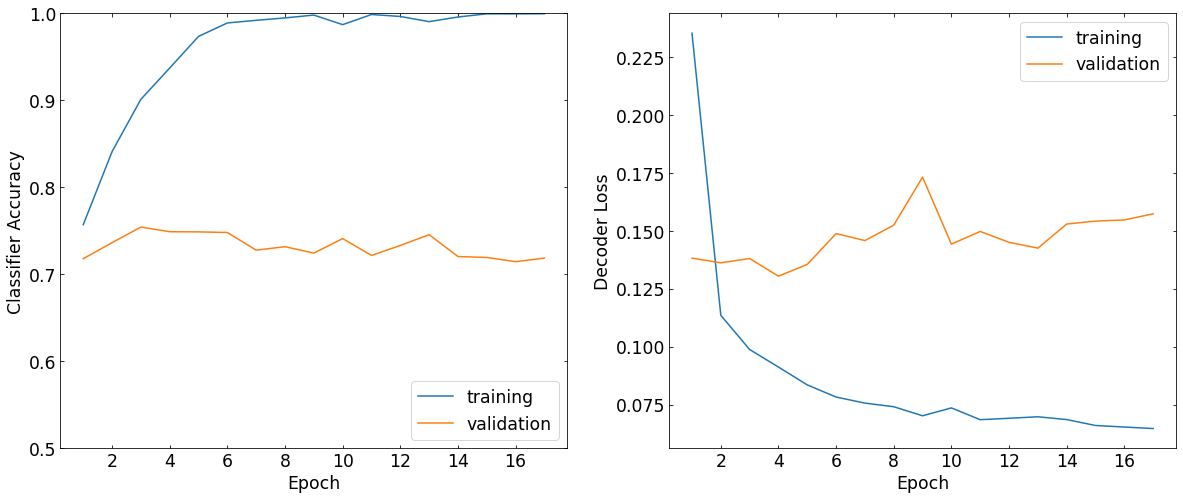

In [12]:
x = train_log.epoch + 1

font = {'size': 12}
plt.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

ax1.plot(x, train_log.capsnet_accuracy, label = 'training')
ax1.plot(x, train_log.val_capsnet_accuracy, label = 'validation')
ax1.legend(loc = 'lower right')
ax1.set_ylim([0.5, 1])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Classifier Accuracy')

ax2.plot(x, train_log.decoder_model_loss, label = 'training')
ax2.plot(x, train_log.val_decoder_model_loss, label = 'validation')
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Decoder Loss')



## Classifier Evaluation

In [13]:
from sklearn.metrics import classification_report

In [14]:
train_model, eval_model, manipulate_model, decoder = CapsNet(verbose = False, **config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32)
Instructions for updating:
dim is deprecated, use axis instead


In [21]:
EVAL_EPOCH = 9
weights_path = path_output / config["run_name"] / DATE / 'weights' / f'weights-0{EVAL_EPOCH}.h5'
eval_model.load_weights(weights_path)
manipulate_model.load_weights(weights_path)

In [22]:
masked_capsules, capsules, capsule_sizes, decoded_imgs = eval_model.predict(x_dev)
decoded_imgs.shape

(3605, 200, 200, 1)

In [23]:
y_pred = np.argmax(capsule_sizes, axis = 1)
y_true = np.argmax(y_dev, axis = 1)
target_names = ['No Eye', 'Eye']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      No Eye       0.88      0.78      0.83      2787
         Eye       0.47      0.65      0.54       818

    accuracy                           0.75      3605
   macro avg       0.68      0.72      0.69      3605
weighted avg       0.79      0.75      0.76      3605



## Decoder Visualization

In [24]:
dev = aux_dev.reset_index(drop = True)
dev[dev.wind > 130].head(10)

,category_num,wind,eye,nan_frac,lat,lon,pressure_min,distance,age,synoptic
581,2,133.333333,1,0.0,NaN,NaN,NaN,NaN,NaN,0
582,2,134.166667,1,0.0,NaN,NaN,NaN,NaN,NaN,0
583,2,135.000000,1,0.0,16.6,56.4,933.0,829.0,144.0,1
584,2,136.250000,1,0.0,NaN,NaN,NaN,NaN,NaN,0
585,2,137.500000,1,0.0,NaN,NaN,NaN,NaN,NaN,0
586,2,147.500000,1,0.0,NaN,NaN,NaN,NaN,NaN,0
587,2,148.750000,1,0.0,NaN,NaN,NaN,NaN,NaN,0
588,2,150.000000,1,0.0,16.7,57.8,929.0,756.0,150.0,1
589,2,150.416667,1,0.0,NaN,NaN,NaN,NaN,NaN,0
590,2,150.833333,1,0.0,NaN,NaN,NaN,NaN,NaN,0


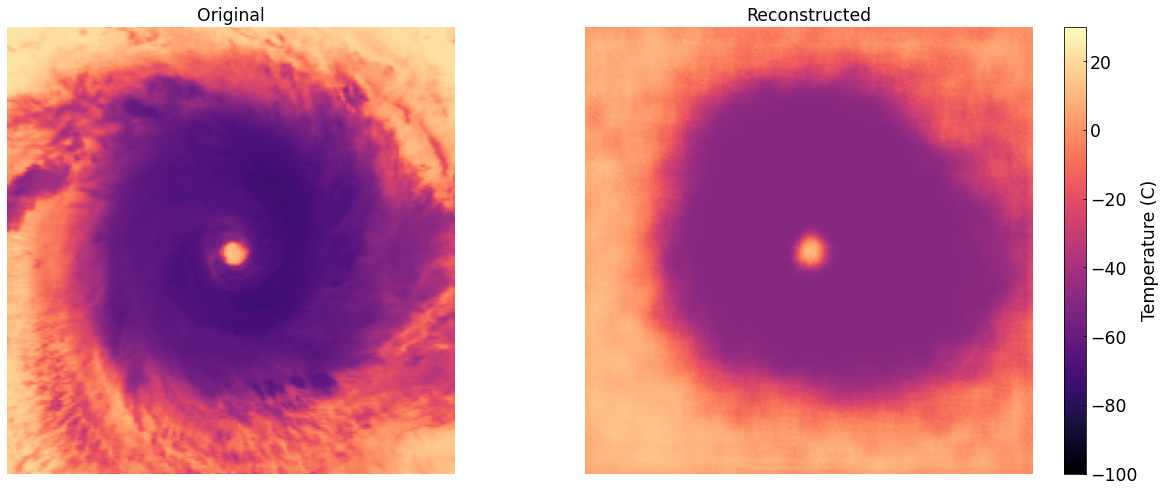

In [25]:
img_indx = 590

scale = config['image_scale']
#min_val = np.min(np.concatenate((x_dev*scale, decoded_imgs*scale)))
#max_val = np.max(np.concatenate((x_dev*scale, decoded_imgs*scale)))

min_val = -100
max_val = 30

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7))
ax1.imshow(x_dev[img_indx]*scale, aspect="equal", cmap = 'magma', vmin = min_val, vmax = max_val)
ax1.set_title('Original')
ax1.axis('off')
im = ax2.imshow(decoded_imgs[img_indx]*scale, aspect="equal", cmap = 'magma', vmin = min_val, vmax = max_val)
ax2.set_title('Reconstructed')
ax2.axis('off')

fig.colorbar(im, label = 'Temperature (C)')
fig.tight_layout()

plt.show()


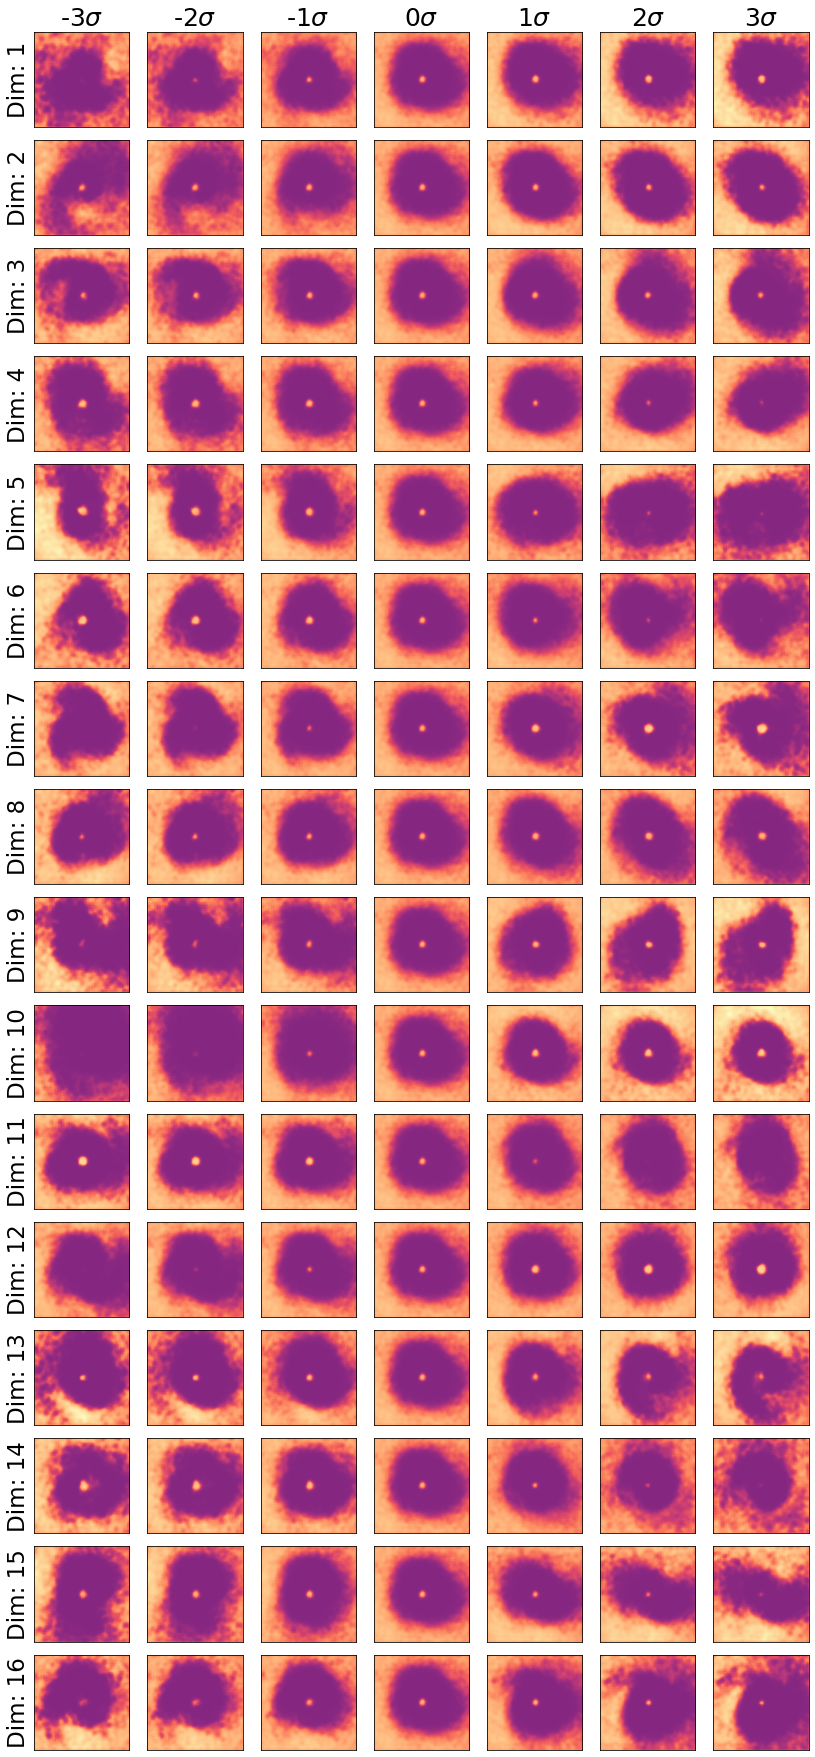

In [26]:
sigma_arr = np.std(masked_capsules, axis=0)
sigma_arr

caps_gal = masked_capsules[img_indx].copy()

change_grid = [-3,-2,-1,0,1,2,3]
num_caps=16
fig, axs = plt.subplots(num_caps,len(change_grid), figsize=(1.4*8.3,2.1*11.7))

for caps_index in range(num_caps):
    for j in range(len(change_grid)):
        tinkered_dim = caps_gal[caps_index] + change_grid[j] * sigma_arr[caps_index]
        tinkered_caps = caps_gal.copy()
        tinkered_caps[caps_index] = tinkered_dim
        tinkered_recon = decoder.predict(np.expand_dims(tinkered_caps, axis=0))[0]
        axs[caps_index][j].imshow(tinkered_recon*scale, aspect="equal", cmap = 'magma', vmin = min_val, vmax = max_val)
        axs[caps_index][j].axes.get_xaxis().set_ticks([])
        axs[caps_index][j].axes.get_yaxis().set_ticks([])

cols = ['{}$\sigma$'.format(col) for col in change_grid]
rows = ['Dim: {}'.format(row) for row in np.arange(1,num_caps+1).astype(str) ]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=25)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size=23)

plt.tight_layout()